In [1]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import numpy as np
import pandas as pd
import pylab 
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import ListedColormap
%matplotlib inline
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
from graphviz import Source
from IPython.display import Image

from scipy.stats import skew, norm, probplot, boxcox, f_oneway
from scipy import interp
from sklearn.base import BaseEstimator, TransformerMixin, clone, ClassifierMixin
from sklearn import metrics, tree
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler, PolynomialFeatures, MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_val_predict, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score

from sklearn.linear_model import LogisticRegression
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.tree import DecisionTreeClassifier
#import xgboost as xgb
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
#from mlxtend.classifier import StackingClassifier

from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

In [2]:
wines_noise = pd.read_csv('../../NumericData/20_noisy_winequality.csv')

wines_noise['quality_label'] = wines_noise.quality.apply(lambda q: 'low' if q <= 5 else 'medium' if q <= 7 else 'high')
#wines.quality_label = pd.Categorical(wines.quality_label, categories=['low', 'medium', 'high'], ordered=True)

# re-shuffle records just to randomize data points
wines_noise = wines_noise.sample(frac=1, random_state=101).reset_index(drop=True)

In [3]:
wines_original = pd.read_csv('../../NumericData/winequality.csv')

wines_original['quality_label'] = wines_original.quality.apply(lambda q: 'low' if q <= 5 else 'medium' if q <= 7 else 'high')
#wines.quality_label = pd.Categorical(wines.quality_label, categories=['low', 'medium', 'high'], ordered=True)

# re-shuffle records just to randomize data points
wines_original = wines_original.sample(frac=1, random_state=101).reset_index(drop=True)

In [4]:
def rstr(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()])
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis = 1)

    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis = 1, sort=False)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ration', 'uniques', 'skewness', 'kurtosis', corr_col ]
    
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str

In [5]:
details = rstr(wines_noise, 'quality')
details.sort_values(by='missing_ration', ascending=False)

Data shape: (6497, 14)
___________________________
Data types:
 float64    11
object      2
int64       1
Name: types, dtype: int64
___________________________


types  counts  distincts  nulls  missing_ration  \
fixed acidity         float64    6490        918      7        0.107742   
volatile acidity      float64    6490        232      7        0.107742   
pH                    float64    6490        131      7        0.107742   
sulphates             float64    6493        180      4        0.061567   
citric acid           float64    6495        168      2        0.030783   
residual sugar        float64    6496       1727      1        0.015392   
chlorides             float64    6496        234      1        0.015392   
type                   object    6497          2      0        0.000000   
free sulfur dioxide   float64    6497       1771      0        0.000000   
total sulfur dioxide  float64    6497       1899      0        0.000000   
density               float64    6497        928      0        0.000000   
alcohol               float64    6497        658      0        0.000000   
quality                 int64    6497          7      0        0.000000   
quality_label          object    6497          3      0        0.000000   

                                                                uniques  \
fixed acidity         [[7.3, 6.9, 9.5, 8.2, 7.9, 9.8, 7.0, 4.46, 6.5...   
volatile acidity      [[0.28, 0.34, 0.46, 0.27, 0.13, 0.25, 0.38, 0....   
pH                    [[3.28, 3.51, 3.12, 3.09, 3.32, 2.95, 3.05, 3....   
sulphates             [[0.82, 0.43, 0.68, 1.68, 0.55, 1.27, 0.59, 0....   
citric acid           [[0.42, 0.66, 0.62, 0.4, 0.47, 0.85, 0.37, 0.2...   
residual sugar        [[14.4, 2.1, 2.7, 2.2, 4.9, 1.4, 12.85, 2.0, 1...   
chlorides             [[0.04, 0.11, 0.15, 0.057999999999999996, 0.03...   
type                                                     [[white, red]]   
free sulfur dioxide   [[49.0, 12.0, 181.39, 6.0, 31.0, 3.0, 36.0, 55...   
total sulfur dioxide  [[173.0, 372.41, 426.18, 10.0, 153.0, 328.0, 1...   
density               [[1.03, 0.9948, 0.998, 1.0, 0.9966, 0.9947, 0....   
alcohol               [[9.0, 11.4, 10.0, 12.2, 9.7, 10.7, 9.5, 10.4,...   
quality                                         [[7, 4, 6, 5, 8, 3, 9]]   
quality_label                                     [[medium, low, high]]   

                      skewness  kurtosis  corr quality  
fixed acidity         1.507211  1.891671     -0.022972  
volatile acidity      1.595626  1.770231     -0.087621  
pH                    0.771275  0.721176     -0.008400  
sulphates             1.816012  2.622200      0.011067  
citric acid           1.691209  2.341285      0.017191  
residual sugar        1.799219  2.227092     -0.002202  
chlorides             1.923610  2.450753     -0.052607  
type                       NaN       NaN           NaN  
free sulfur dioxide   1.887555  2.562105      0.018788  
total sulfur dioxide  1.086923  1.125950     -0.013319  
density               1.991814  3.148964     -0.049038  
alcohol               0.669033 -0.247389      0.268212  
quality               0.189623  0.232322      1.000000  
quality_label              NaN       NaN           NaN

In [6]:
wines_noise.quality_label.value_counts()


medium    3915
low       2384
high       198
Name: quality_label, dtype: int64

In [7]:
wines_noise.dropna().quality_label.value_counts()


medium    3901
low       2373
high       198
Name: quality_label, dtype: int64

In [8]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """
        Impute missing values:
        - Columns of dtype object are imputed with the most frequent value in column.
        - Columns of other types are imputed with mean of column.
        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

wines_noise = DataFrameImputer().fit_transform(wines_noise)
wines_noise.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.3              0.28         0.42            14.4   
1    red            6.9              0.34         0.66             2.1   
2    red            9.5              0.46         0.62             2.7   
3    red            8.2              0.27         0.40             2.2   
4  white            7.9              0.28         0.47             4.9   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.040                49.00                173.00   1.0300  3.28   
1      0.110                12.00                372.41   0.9948  3.51   
2      0.150               181.39                426.18   0.9980  3.12   
3      0.058                 6.00                 10.00   1.0000  3.09   
4      0.030                31.00                153.00   0.9966  3.32   

   sulphates  alcohol  quality quality_label  
0       0.82      9.0        7        medium  
1       0.43     11.4        4           low  
2       0.68     10.0        6        medium  
3       0.68     12.2        7        medium  
4       1.68      9.7        6        medium

In [9]:
wines_original.quality_label.value_counts()


medium    3915
low       2384
high       198
Name: quality_label, dtype: int64

In [10]:
wines_original.dropna().quality_label.value_counts()


medium    3894
low       2372
high       197
Name: quality_label, dtype: int64

In [11]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """
        Impute missing values:
        - Columns of dtype object are imputed with the most frequent value in column.
        - Columns of other types are imputed with mean of column.
        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

wines_original = DataFrameImputer().fit_transform(wines_original)
wines_original.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.3              0.28         0.42            14.4   
1    red            6.9              1.09         0.06             2.1   
2    red            9.5              0.46         0.24             2.7   
3    red            8.2              0.31         0.40             2.2   
4  white            7.9              0.28         0.41             4.9   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.040                 49.0                 173.0  0.99940  3.28   
1      0.061                 12.0                  31.0  0.99480  3.51   
2      0.092                 14.0                  44.0  0.99800  3.12   
3      0.058                  6.0                  10.0  0.99536  3.31   
4      0.058                 31.0                 153.0  0.99660  3.27   

   sulphates  alcohol  quality quality_label  
0       0.82      9.0        7        medium  
1       0.43     11.4        4           low  
2       0.74     10.0        6        medium  
3       0.68     11.2        7        medium  
4       0.51      9.7        6        medium

In [12]:
#Descriptive Statistics_ByType
subset_attributes = wines_noise.columns
rs = round(wines_noise.loc[wines_noise.type == 'red', subset_attributes].describe(),2)
ws = round(wines_noise.loc[wines_noise.type == 'white', subset_attributes].describe(),2)
pd.concat([rs, ws], axis=0, keys=['Red Wine Statistics', 'White Wine Statistics']).T

Red Wine Statistics                                      \
                                   count    mean     std   min    25%    50%   
fixed acidity                     2046.0    8.34    2.46  3.81   6.70   7.60   
volatile acidity                  2046.0    0.54    0.32  0.08   0.30   0.47   
citric acid                       2046.0    0.44    0.38  0.00   0.20   0.34   
residual sugar                    2046.0   11.71   16.67  0.64   2.00   2.80   
chlorides                         2046.0    0.14    0.15  0.01   0.06   0.08   
free sulfur dioxide               2046.0   56.09   72.40  1.42  12.00  25.00   
total sulfur dioxide              2046.0  113.09  102.00  6.00  34.00  85.00   
density                           2046.0    1.00    0.01  0.99   0.99   1.00   
pH                                2046.0    3.30    0.24  2.72   3.15   3.28   
sulphates                         2046.0    0.73    0.37  0.23   0.51   0.62   
alcohol                           2046.0   10.72    1.51  8.01   9.50  10.40   
quality                           2046.0    5.71    0.84  3.00   5.00   6.00   

                                     White Wine Statistics                 \
                         75%     max                 count    mean    std   
fixed acidity           9.45   15.90                4451.0    7.67   2.31   
volatile acidity        0.67    1.58                4451.0    0.43   0.35   
citric acid             0.52    1.65                4451.0    0.46   0.35   
residual sugar         13.04   65.67                4451.0   13.08  15.70   
chlorides               0.12    0.61                4451.0    0.12   0.15   
free sulfur dioxide    55.00  288.49                4451.0   62.90  65.81   
total sulfur dioxide  153.00  438.46                4451.0  156.69  83.93   
density                 1.00    1.04                4451.0    1.00   0.01   
pH                      3.41    4.01                4451.0    3.24   0.25   
sulphates               0.81    2.00                4451.0    0.65   0.38   
alcohol                11.60   14.90                4451.0   10.75   1.51   
quality                 6.00    8.00                4451.0    5.87   0.88   

                                                            
                       min     25%     50%     75%     max  
fixed acidity         3.80    6.40    7.00    8.00   15.89  
volatile acidity      0.08    0.22    0.29    0.45    1.58  
citric acid           0.00    0.27    0.34    0.49    1.66  
residual sugar        0.60    2.10    7.40   14.80   65.69  
chlorides             0.01    0.04    0.05    0.09    0.61  
free sulfur dioxide   1.00   25.00   39.00   62.00  288.50  
total sulfur dioxide  6.00  104.06  141.00  186.00  440.00  
density               0.99    0.99    1.00    1.00    1.04  
pH                    2.72    3.08    3.20    3.35    4.01  
sulphates             0.22    0.43    0.51    0.67    2.00  
alcohol               8.00    9.50   10.50   11.80   14.90  
quality               3.00    5.00    6.00    6.00    9.00

In [13]:
#Descriptive Statistics_ByQuality
#subset_attributes = ['alcohol', 'volatile acidity', 'pH', 'quality']
ls = round(wines_noise[wines_noise['quality_label'] == 'low'][subset_attributes].describe(),2)
ms = round(wines_noise[wines_noise['quality_label'] == 'medium'][subset_attributes].describe(),2)
hs = round(wines_noise[wines_noise['quality_label'] == 'high'][subset_attributes].describe(),2)
pd.concat([ls, ms, hs], axis=0, keys=['Low Quality Wine', 'Medium Quality Wine', 'High Quality Wine']).T

Low Quality Wine                                      \
                                count    mean    std   min    25%     50%   
fixed acidity                  2384.0    7.93   2.29  3.81   6.50    7.30   
volatile acidity               2384.0    0.50   0.33  0.08   0.27    0.38   
citric acid                    2384.0    0.45   0.37  0.00   0.22    0.34   
residual sugar                 2384.0   12.76  15.83  0.60   2.00    6.50   
chlorides                      2384.0    0.13   0.15  0.01   0.05    0.06   
free sulfur dioxide            2384.0   59.33  68.19  1.75  17.00   34.00   
total sulfur dioxide           2384.0  143.62  92.71  6.00  75.39  135.00   
density                        2384.0    1.00   0.01  0.99   0.99    1.00   
pH                             2384.0    3.26   0.25  2.72   3.10    3.22   
sulphates                      2384.0    0.67   0.38  0.22   0.45    0.53   
alcohol                        2384.0   10.25   1.41  8.00   9.30    9.80   
quality                        2384.0    4.88   0.36  3.00   5.00    5.00   

                                     Medium Quality Wine           ...    \
                         75%     max               count    mean   ...     
fixed acidity           8.51   15.90              3915.0    7.86   ...     
volatile acidity        0.63    1.58              3915.0    0.44   ...     
citric acid             0.51    1.65              3915.0    0.46   ...     
residual sugar         15.12   65.57              3915.0   12.62   ...     
chlorides               0.11    0.61              3915.0    0.12   ...     
free sulfur dioxide    61.00  288.50              3915.0   61.42   ...     
total sulfur dioxide  186.00  440.00              3915.0  142.76   ...     
density                 1.00    1.04              3915.0    1.00   ...     
pH                      3.37    4.00              3915.0    3.26   ...     
sulphates               0.70    2.00              3915.0    0.68   ...     
alcohol                10.80   14.90              3915.0   10.99   ...     
quality                 5.00    5.00              3915.0    6.28   ...     

                                     High Quality Wine                       \
                         75%     max             count    mean    std   min   
fixed acidity           8.40   15.89             198.0    7.70   2.37  4.06   
volatile acidity        0.52    1.58             198.0    0.42   0.30  0.09   
citric acid             0.49    1.66             198.0    0.45   0.33  0.01   
residual sugar         14.12   65.69             198.0   12.00  13.72  0.80   
chlorides               0.10    0.61             198.0    0.10   0.14  0.01   
free sulfur dioxide    60.00  288.44             198.0   64.78  69.31  5.00   
total sulfur dioxide  174.56  438.84             198.0  138.98  88.24  7.57   
density                 1.00    1.04             198.0    1.00   0.01  0.99   
pH                      3.37    4.01             198.0    3.24   0.23  2.75   
sulphates               0.74    2.00             198.0    0.71   0.42  0.25   
alcohol                12.00   14.90             198.0   11.55   1.59  8.09   
quality                 7.00    7.00             198.0    8.03   0.16  8.00   

                                                     
                        25%     50%     75%     max  
fixed acidity          6.32    7.00    8.00   15.86  
volatile acidity       0.22    0.32    0.46    1.56  
citric acid            0.28    0.34    0.45    1.66  
residual sugar         2.60    6.45   14.20   61.90  
chlorides              0.03    0.04    0.07    0.61  
free sulfur dioxide   29.00   39.00   56.00  288.25  
total sulfur dioxide  90.71  120.00  155.00  437.49  
density                0.99    0.99    1.00    1.04  
pH                     3.10    3.22    3.36    4.00  
sulphates              0.41    0.57    0.84    1.98  
alcohol               10.50   11.90   12.60   14.85  
quality                8.00    8.00    8.00    9.00  

[12 rows x 24

In [14]:
# re-shuffle records just to randomize data points
wines_noise = wines_noise.sample(frac=1, random_state=101).reset_index(drop=True)

class_tp = LabelEncoder()
y_tp = class_tp.fit_transform(wines_noise.type.values) # 1 - White; 0 - Red
wines_noise['color'] = y_tp

class_ql = {'low':0, 'medium': 1, 'high': 2}
y_ql = wines_noise.quality_label.map(class_ql)

In [15]:
# re-shuffle records just to randomize data points
wines_original = wines_original.sample(frac=1, random_state=101).reset_index(drop=True)

class_tp = LabelEncoder()
y_tp = class_tp.fit_transform(wines_original.type.values) # 1 - White; 0 - Red
wines_original['color'] = y_tp

class_ql = {'low':0, 'medium': 1, 'high': 2}
y_ql = wines_original.quality_label.map(class_ql)

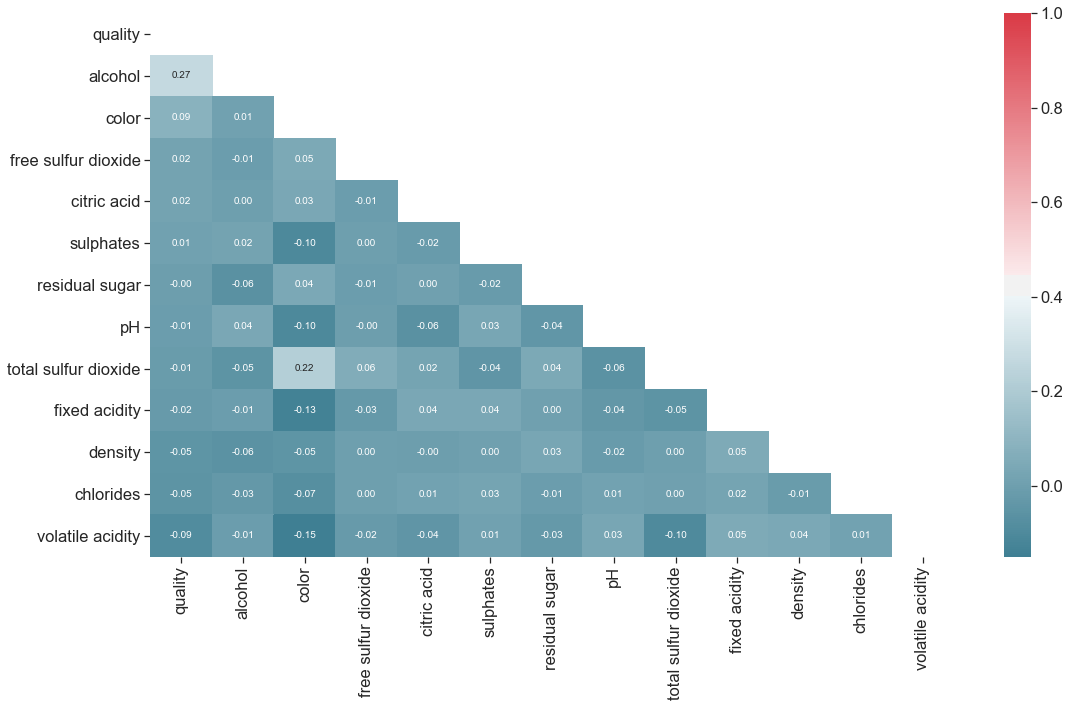

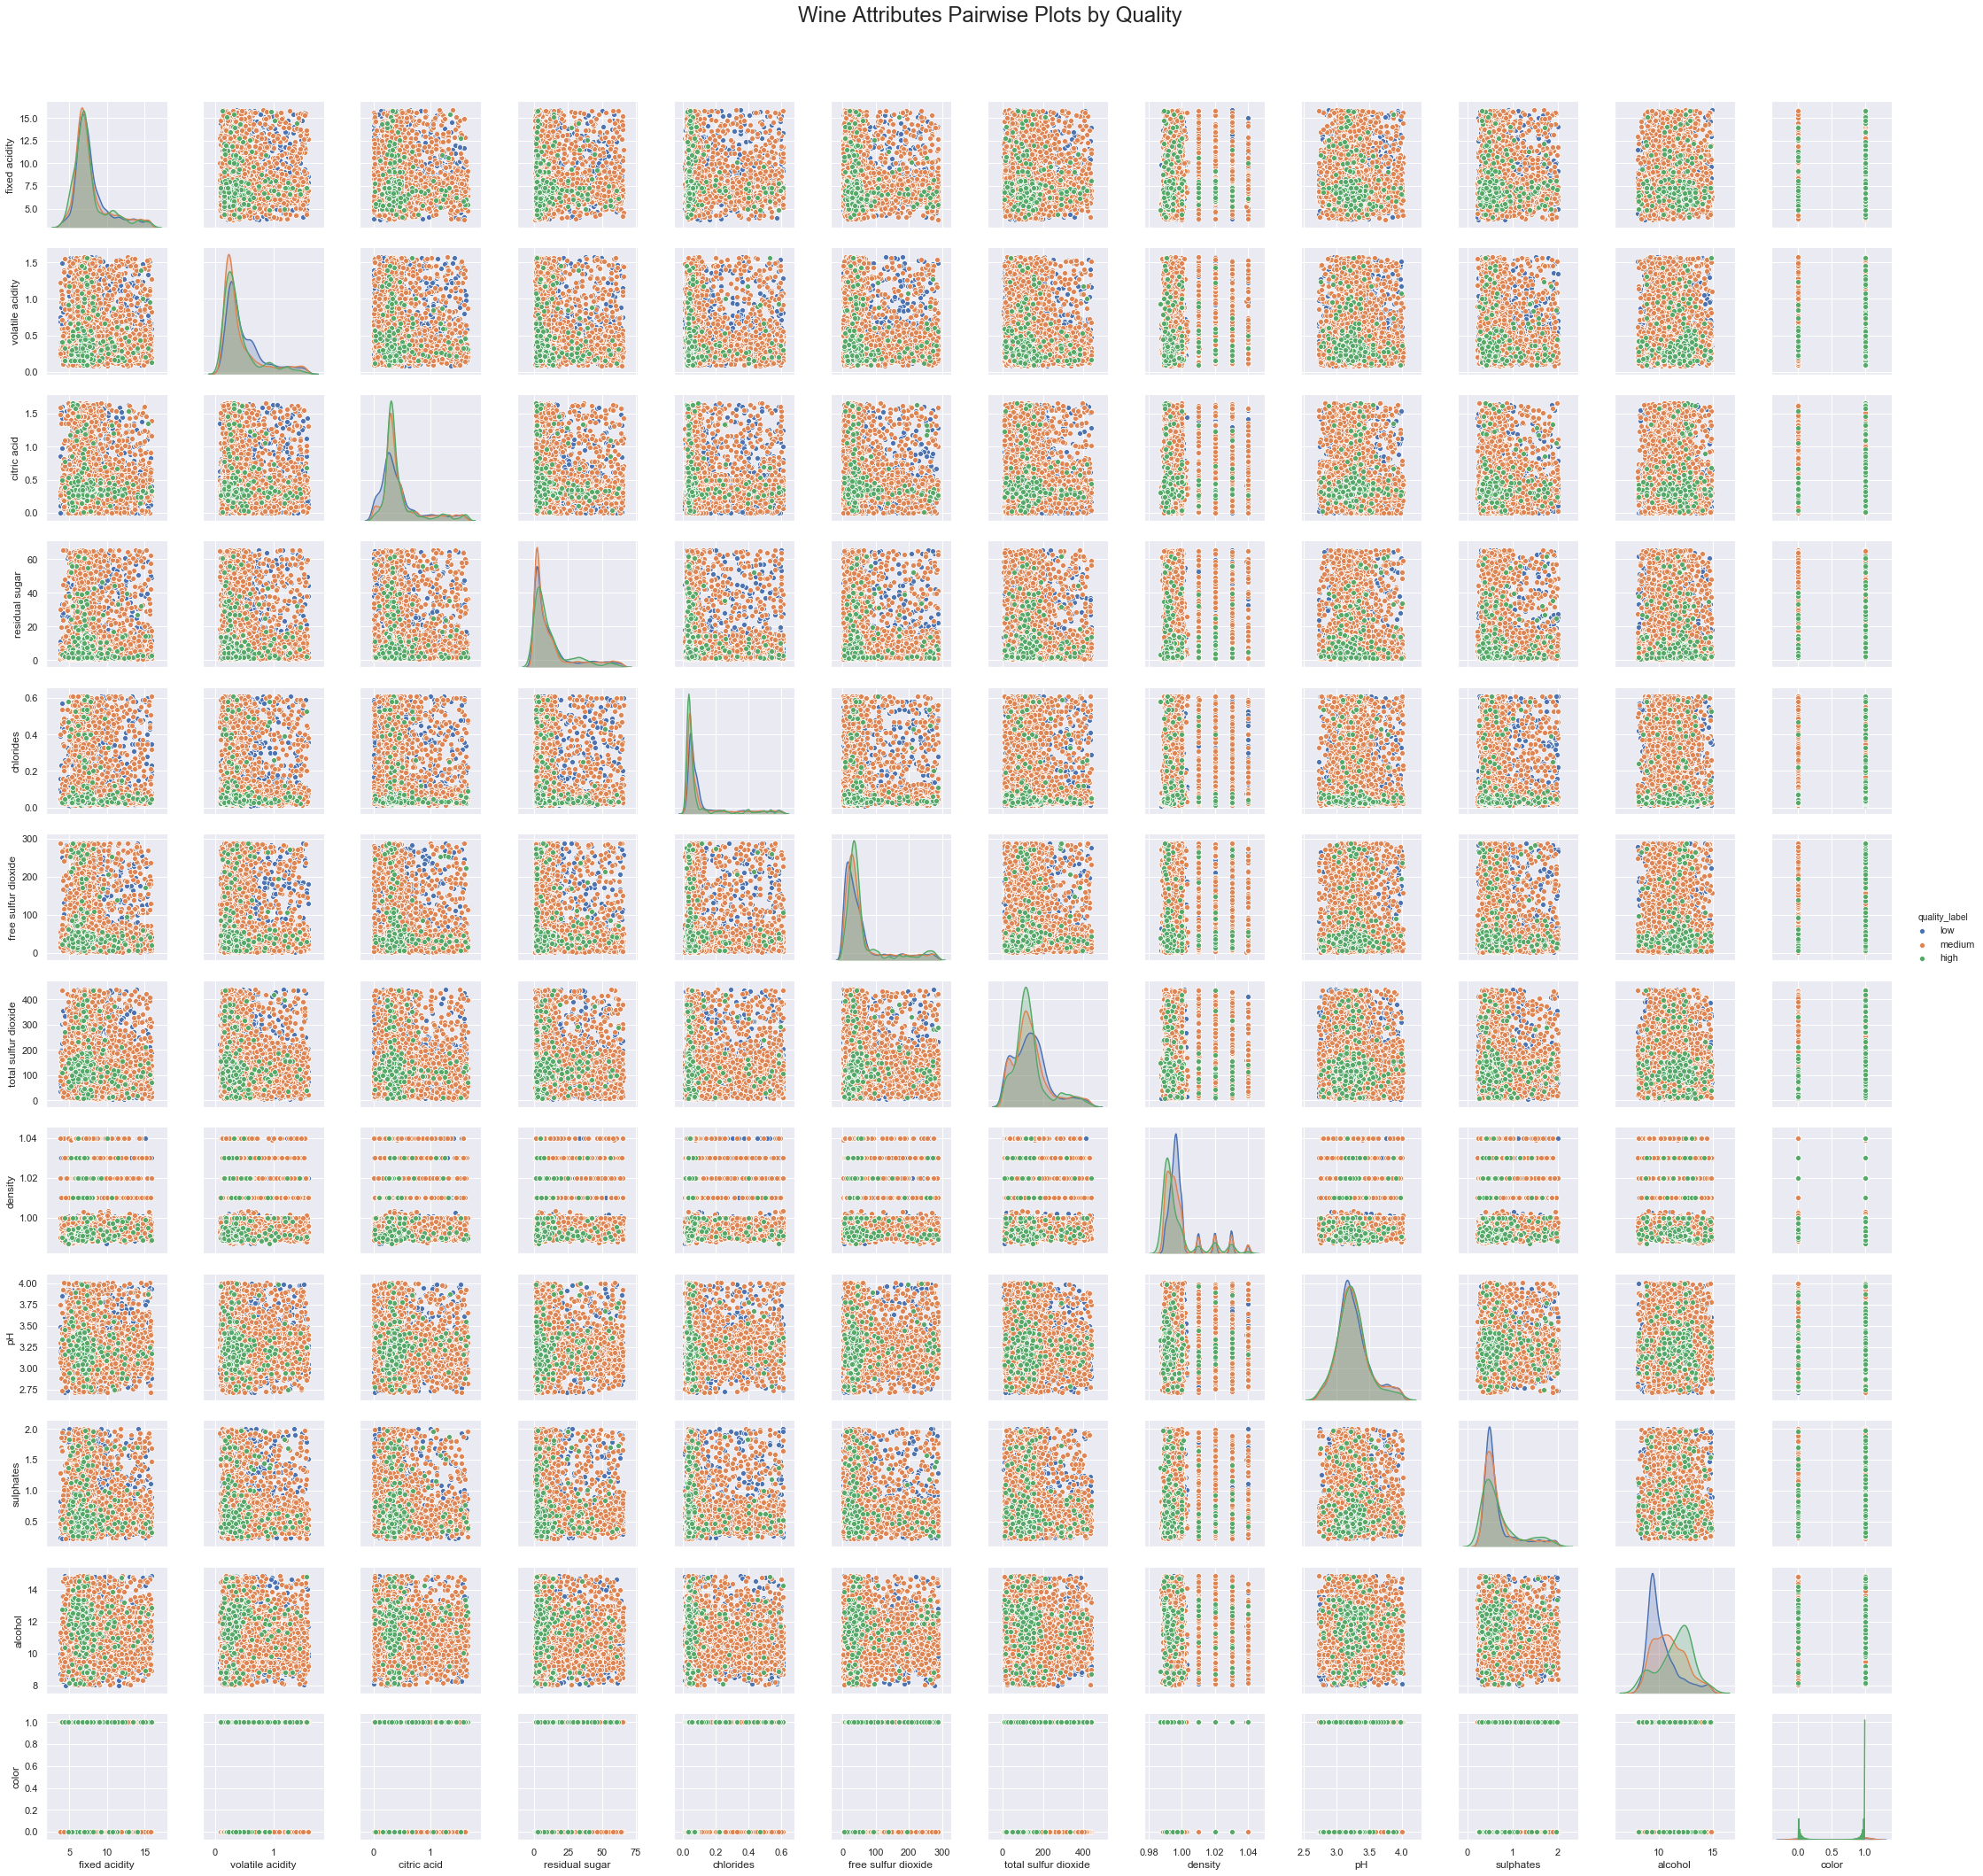

In [16]:
corr = wines_noise.corr()
top_corr_cols = corr.quality.sort_values(ascending=False).keys() 
top_corr = corr.loc[top_corr_cols, top_corr_cols]
dropSelf = np.zeros_like(top_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
plt.figure(figsize=(18, 10))
sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
sns.set(font_scale=1.5)

sns.set(font_scale=1.0)
cols = wines_noise.columns
cols = cols.drop('quality')
g = sns.pairplot(data = wines_noise.loc[:, cols], hue='quality_label')
fig = g.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Wine Attributes Pairwise Plots by Quality', fontsize=24)

plt.show()

del corr, dropSelf, top_corr, g, fig, t


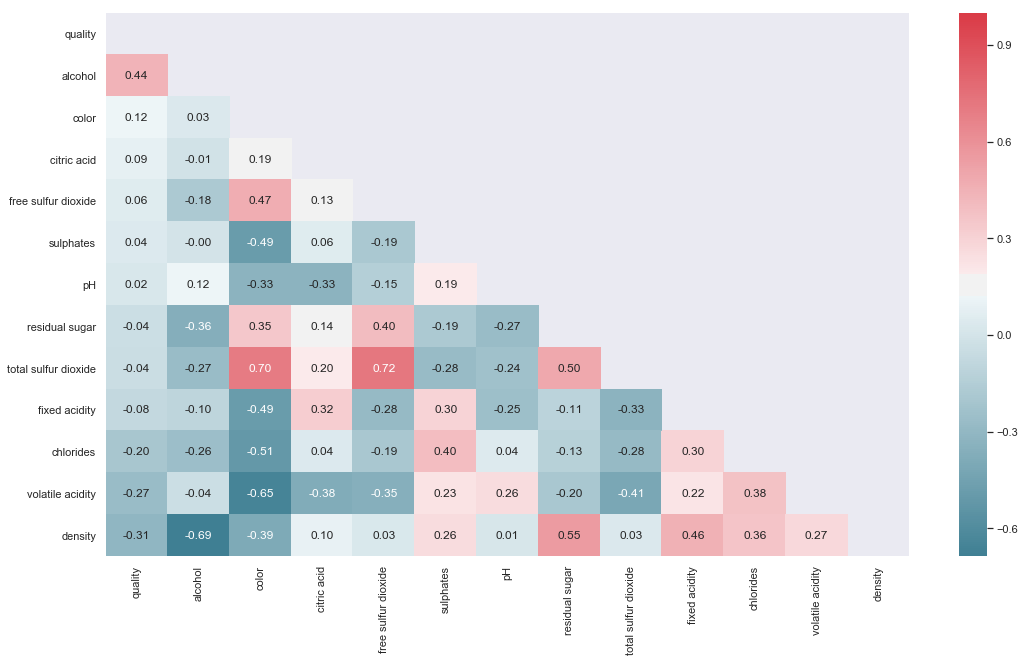

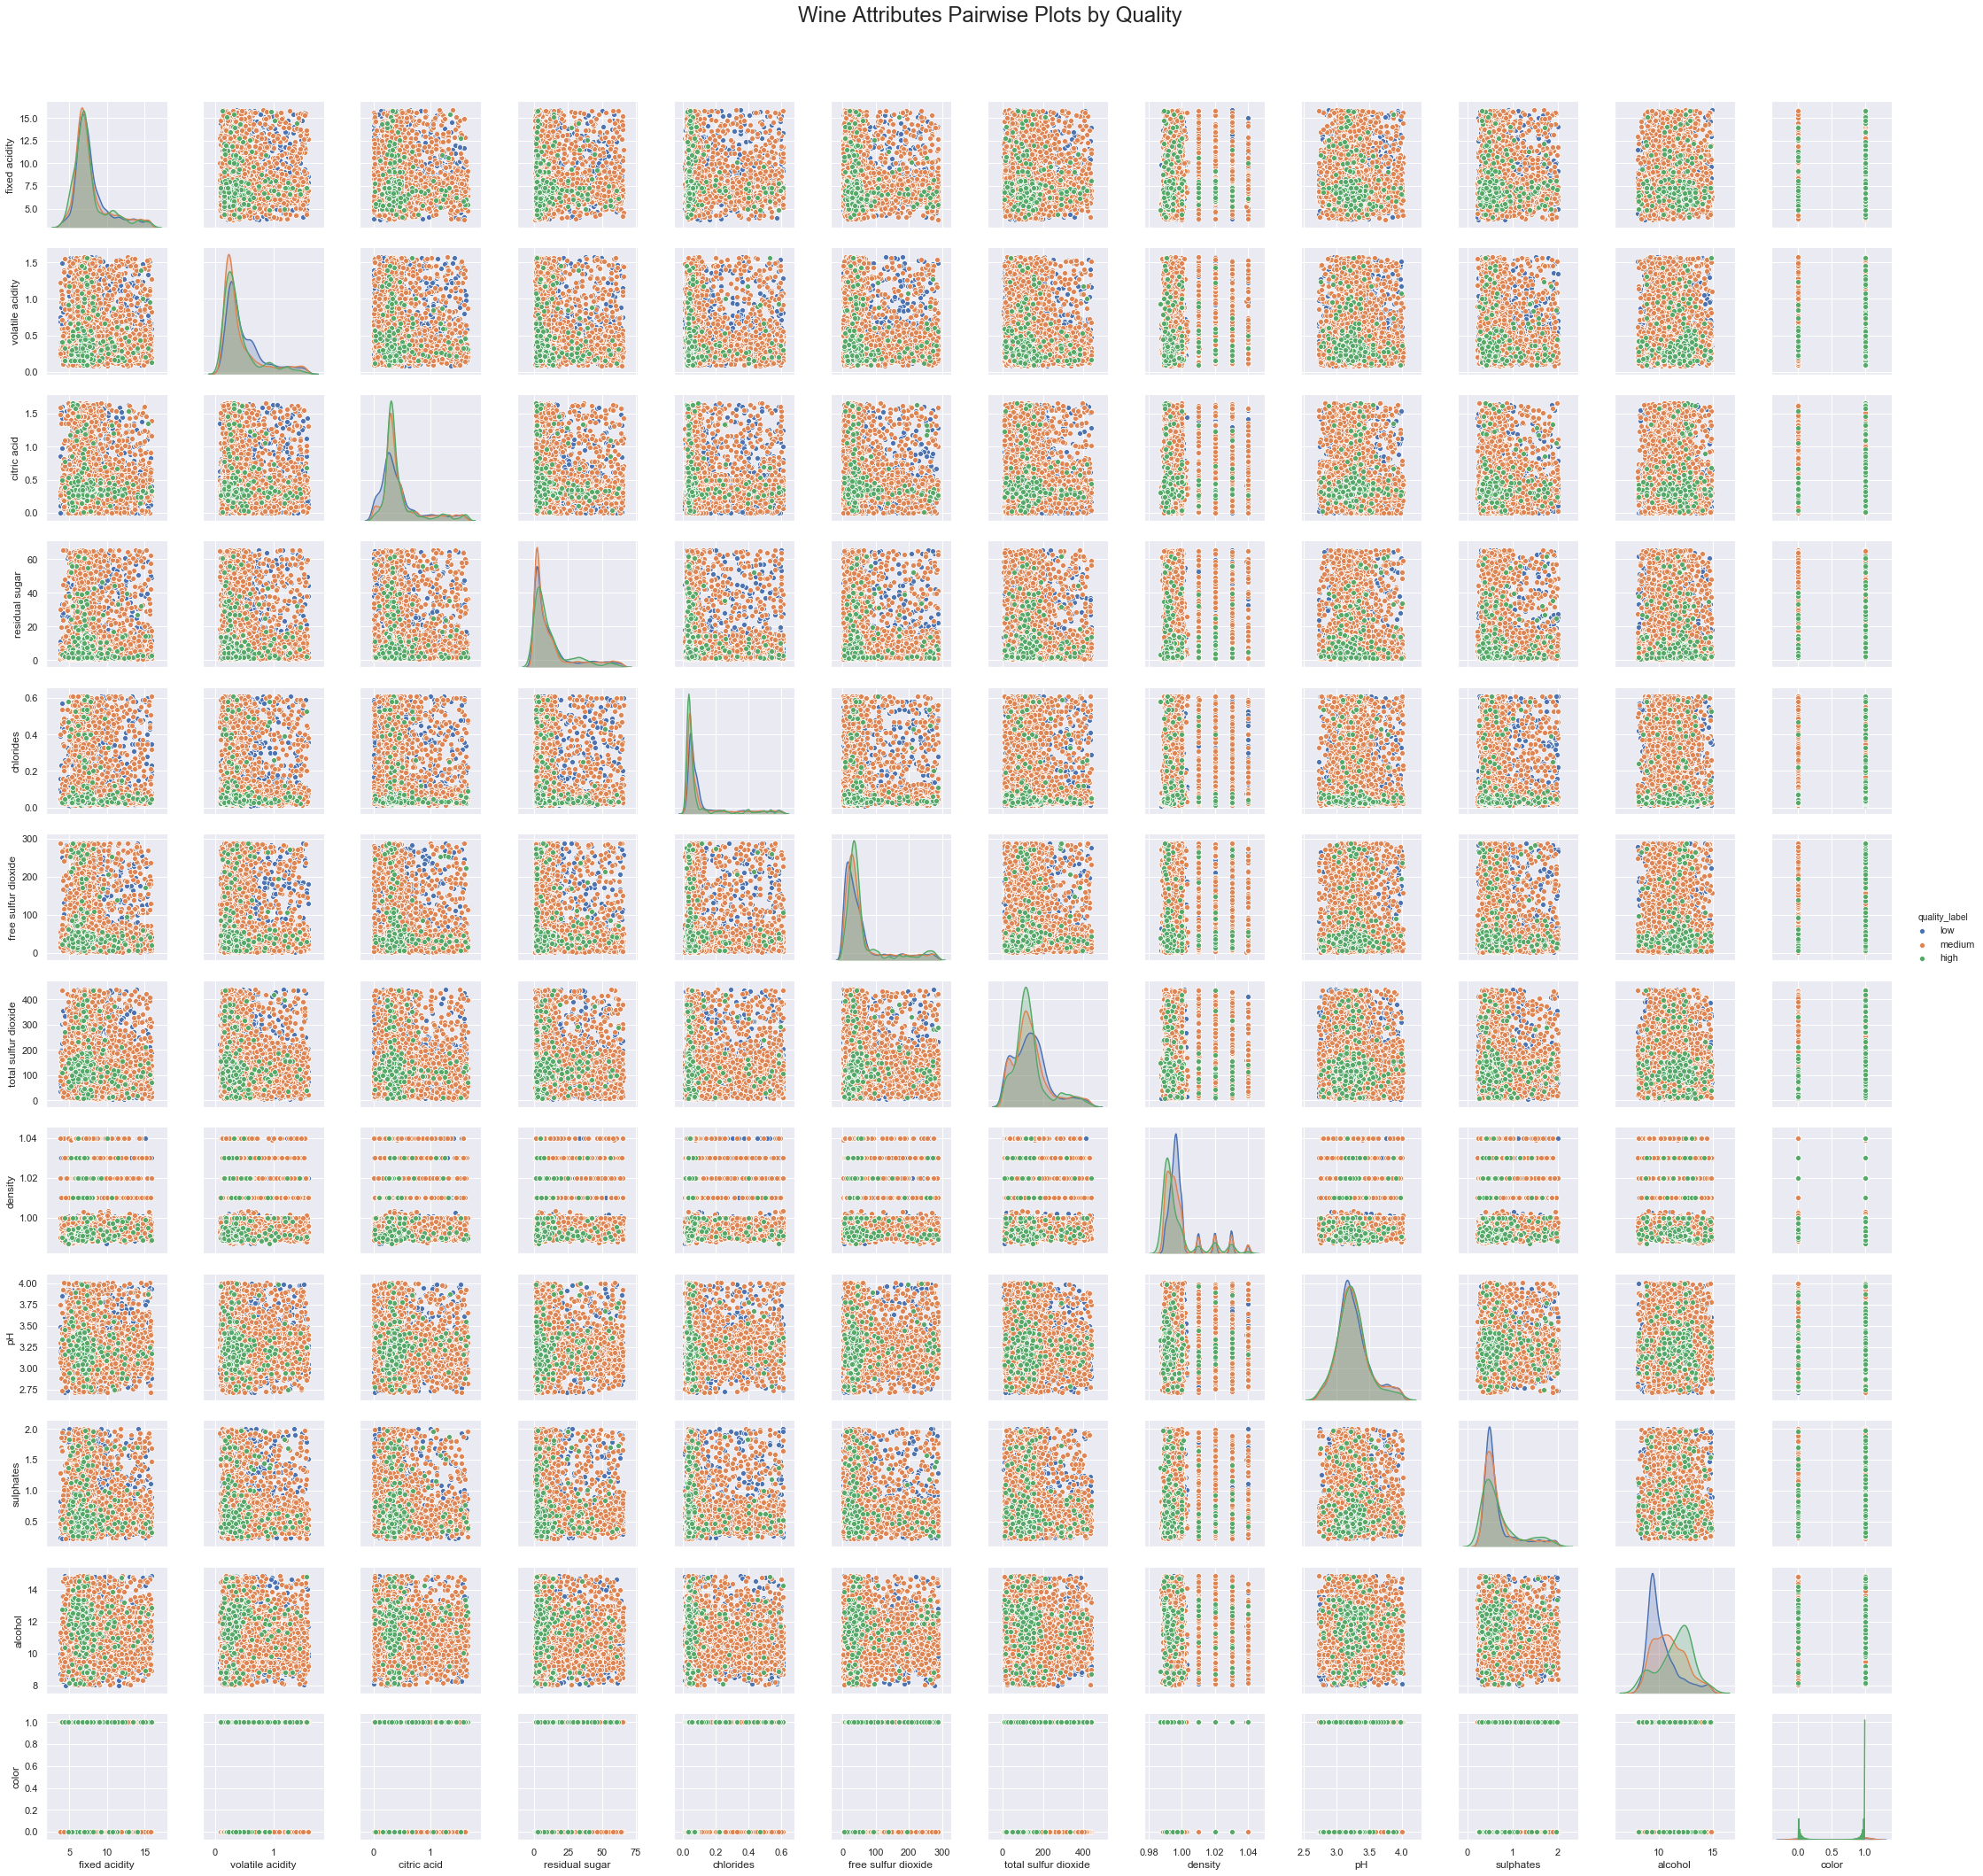

In [17]:
corr = wines_original.corr()
top_corr_cols = corr.quality.sort_values(ascending=False).keys() 
top_corr = corr.loc[top_corr_cols, top_corr_cols]
dropSelf = np.zeros_like(top_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
plt.figure(figsize=(18, 10))
sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
sns.set(font_scale=1.5)

sns.set(font_scale=1.0)
cols = wines_original.columns
cols = cols.drop('quality')
g = sns.pairplot(data = wines_noise.loc[:, cols], hue='quality_label')
fig = g.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Wine Attributes Pairwise Plots by Quality', fontsize=24)

plt.show()

del corr, dropSelf, top_corr, g, fig, t


In [18]:
numeric_features = list(wines_noise.dtypes[(wines_noise.dtypes != "str") & (wines_noise.dtypes !='object')].index)
numeric_features.remove('color')

skewed_features = wines_noise[numeric_features].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness = pd.DataFrame({'Skew' :skewed_features})   

# Get only higest skewed features
skewness = skewness[abs(skewness) > 0.7]
skewness = skewness.dropna()
print ("There are {} higest skewed numerical features to box cox transform".format(skewness.shape[0]))

l_opt = {}

for feat in skewness.index:
    wines_noise[feat], l_opt[feat] = boxcox((wines_noise[feat]+1))

skewed_features2 = wines_noise[skewness.index].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness2 = pd.DataFrame({'New Skew' :skewed_features2})   
display(pd.concat([skewness, skewness2], axis=1).sort_values(by=['Skew'], ascending=False))

There are 10 higest skewed numerical features to box cox transform


Skew  New Skew
density               1.991354  1.568516
chlorides             1.923314  0.783359
free sulfur dioxide   1.887119  0.003420
sulphates             1.816152  0.184014
residual sugar        1.798942  0.130999
citric acid           1.691079  0.025781
volatile acidity      1.596118  0.254378
fixed acidity         1.507675 -0.019388
total sulfur dioxide  1.086672 -0.022481
pH                    0.771512 -0.007488

In [19]:
wines_noise.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0    red       0.724223          0.297556     0.128458        1.599719   
1    red       0.755622          0.276578     0.382643        2.318376   
2    red       0.750787          0.190729     0.427232        1.778893   
3    red       0.717297          0.131279     0.146971        1.550378   
4  white       0.743339          0.133722     0.185146        0.958225   

   chlorides  free sulfur dioxide  total sulfur dioxide   density        pH  \
0   0.034315             3.483596             19.506757  0.021627  0.303826   
1   0.060658             2.314033             13.123592  0.021627  0.304905   
2   0.042040             2.155360             27.789427  0.021627  0.303145   
3   0.036649             3.257650             14.791051  0.021627  0.303932   
4   0.031242             2.062897             16.771104  0.021627  0.303446   

   sulphates  alcohol  quality quality_label  color  
0   0.207930    10.23        5           low      0  
1   0.244054    11.30        4           low      0  
2   0.231898    11.40        5           low      0  
3   0.205678     9.50        6        medium      0  
4   0.254593     9.80        5           low      1

In [20]:
numeric_features = list(wines_original.dtypes[(wines_original.dtypes != "str") & (wines_original.dtypes !='object')].index)
numeric_features.remove('color')

skewed_features = wines_original[numeric_features].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness = pd.DataFrame({'Skew' :skewed_features})   

# Get only higest skewed features
skewness = skewness[abs(skewness) > 0.7]
skewness = skewness.dropna()
print ("There are {} higest skewed numerical features to box cox transform".format(skewness.shape[0]))

l_opt = {}

for feat in skewness.index:
    wines_noise[feat], l_opt[feat] = boxcox((wines_original[feat]+1))

skewed_features2 = wines_original[skewness.index].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness2 = pd.DataFrame({'New Skew' :skewed_features2})   
display(pd.concat([skewness, skewness2], axis=1).sort_values(by=['Skew'], ascending=False))

There are 6 higest skewed numerical features to box cox transform


Skew  New Skew
chlorides            5.399433  5.399433
sulphates            1.798605  1.798605
fixed acidity        1.723733  1.723733
volatile acidity     1.496087  1.496087
residual sugar       1.434889  1.434889
free sulfur dioxide  1.219784  1.219784

In [21]:
wines_original.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            5.9             0.290         0.16             7.9   
1    red           10.1             0.935         0.22             3.4   
2    red            9.1             0.340         0.42             1.8   
3  white            5.4             0.185         0.19             7.1   
4  white            7.9             0.190         0.26             2.1   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.044                 48.0                 197.0  0.99512  3.21   
1      0.105                 11.0                  86.0  1.00100  3.43   
2      0.058                  9.0                  18.0  0.99392  3.18   
3      0.048                 36.0                 110.0  0.99438  3.26   
4      0.039                  8.0                 143.0  0.99420  3.05   

   sulphates  alcohol  quality quality_label  color  
0       0.36      9.4        5           low      1  
1       0.64     11.3        4           low      0  
2       0.55     11.4        5           low      0  
3       0.41      9.5        6        medium      1  
4       0.74      9.8        5           low      1

In [22]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

def VRF(predict, data, y):
   
    scale = StandardScaler(with_std=False)
    df = pd.DataFrame(scale.fit_transform(data), columns= cols)
    features = "+".join(cols)
    df['quality_label'] = y.values

    # get y and X dataframes based on this regression:
    y, X = dmatrices(predict + ' ~' + features, data = df, return_type='dataframe')

   # Calculate VIF Factors
    # For each X, calculate VIF and save in dataframe
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns

    # Inspect VIF Factors
    display(vif.sort_values('VIF Factor'))
    return vif

cols = wines_noise.columns.str.replace(' ', '_')
df = wines_noise.copy()
df.columns = cols
# Remove the not applied to the qualty classification task
cols = list(cols.drop(['type', 'quality_label', 'quality']))

vif = VRF('quality_label', df.loc[:, cols], y_ql)


VIF Factor              features
0     1.000000             Intercept
8     1.054180               density
9     1.080256                    pH
3     1.098730           citric_acid
11    1.128299               alcohol
10    1.258490             sulphates
4     1.273765        residual_sugar
7     1.308780  total_sulfur_dioxide
1     1.346042         fixed_acidity
2     1.482767      volatile_acidity
12    1.522731                 color
6     1.635850   free_sulfur_dioxide
5     1.728645             chlorides

In [23]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

def VRF(predict, data, y):
   
    scale = StandardScaler(with_std=False)
    df = pd.DataFrame(scale.fit_transform(data), columns= cols)
    features = "+".join(cols)
    df['quality_label'] = y.values

    # get y and X dataframes based on this regression:
    y, X = dmatrices(predict + ' ~' + features, data = df, return_type='dataframe')

   # Calculate VIF Factors
    # For each X, calculate VIF and save in dataframe
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns

    # Inspect VIF Factors
    display(vif.sort_values('VIF Factor'))
    return vif

cols = wines_original.columns.str.replace(' ', '_')
df = wines_original.copy()
df.columns = cols
# Remove the not applied to the qualty classification task
cols = list(cols.drop(['type', 'quality_label', 'quality']))

vif = VRF('quality_label', df.loc[:, cols], y_ql)


VIF Factor              features
0     1.000000             Intercept
10    1.553300             sulphates
3     1.620286           citric_acid
5     1.658053             chlorides
2     2.164411      volatile_acidity
6     2.236447   free_sulfur_dioxide
9     2.544397                    pH
7     4.044881  total_sulfur_dioxide
1     5.008898         fixed_acidity
11    5.586239               alcohol
12    7.219469                 color
4     9.586359        residual_sugar
8    22.207092               density

In [24]:
cols = wines_noise.columns.str.replace(' ', '_')
df = wines_noise.copy()
df.columns = cols
# Remove the higest correlations and run a multiple regression
cols = list(cols.drop(['type', 'quality_label', 'quality', 'residual_sugar', 'total_sulfur_dioxide']))

vif = VRF('quality_label', df.loc[:, cols], y_ql)

del df, vif

VIF Factor             features
0     1.000000            Intercept
6     1.038013              density
7     1.072116                   pH
3     1.096471          citric_acid
9     1.103927              alcohol
8     1.250506            sulphates
5     1.301154  free_sulfur_dioxide
1     1.341073        fixed_acidity
2     1.471106     volatile_acidity
10    1.491337                color
4     1.726100            chlorides

In [25]:
cols = wines_original.columns.str.replace(' ', '_')
df = wines_original.copy()
df.columns = cols
# Remove the higest correlations and run a multiple regression
cols = list(cols.drop(['type', 'quality_label', 'quality', 'residual_sugar', 'total_sulfur_dioxide']))

vif = VRF('quality_label', df.loc[:, cols], y_ql)

del df, vif

VIF Factor             features
0     1.000000            Intercept
5     1.445440  free_sulfur_dioxide
8     1.456303            sulphates
3     1.603759          citric_acid
7     1.611557                   pH
4     1.630363            chlorides
2     2.084068     volatile_acidity
1     2.528013        fixed_acidity
9     2.572116              alcohol
6     3.367309              density
10    3.715577                color

In [26]:
wines_original.head()


type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            5.9             0.290         0.16             7.9   
1    red           10.1             0.935         0.22             3.4   
2    red            9.1             0.340         0.42             1.8   
3  white            5.4             0.185         0.19             7.1   
4  white            7.9             0.190         0.26             2.1   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.044                 48.0                 197.0  0.99512  3.21   
1      0.105                 11.0                  86.0  1.00100  3.43   
2      0.058                  9.0                  18.0  0.99392  3.18   
3      0.048                 36.0                 110.0  0.99438  3.26   
4      0.039                  8.0                 143.0  0.99420  3.05   

   sulphates  alcohol  quality quality_label  color  
0       0.36      9.4        5           low      1  
1       0.64     11.3        4           low      0  
2       0.55     11.4        5           low      0  
3       0.41      9.5        6        medium      1  
4       0.74      9.8        5           low      1

In [27]:
wines_noise.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0    red       0.585237          0.160994     0.128458        1.419711   
1    red       0.599249          0.235665     0.382643        1.097168   
2    red       0.597260          0.173996     0.427232        0.832692   
3    red       0.581843          0.123911     0.146971        1.382007   
4  white       0.594065          0.126056     0.185146        0.896790   

   chlorides  free sulfur dioxide  total sulfur dioxide   density        pH  \
0   0.027194            10.219669             19.506757  0.021627  0.303826   
1   0.038760             4.482891             13.123592  0.021627  0.304905   
2   0.031399             3.965127             27.789427  0.021627  0.303145   
3   0.028537             8.777457             14.791051  0.021627  0.303932   
4   0.025330             3.684154             16.771104  0.021627  0.303446   

   sulphates  alcohol  quality quality_label  color  
0   0.198550    10.23        5           low      0  
1   0.253576    11.30        4           low      0  
2   0.240189    11.40        5           low      0  
3   0.211772     9.50        6        medium      0  
4   0.265321     9.80        5           low      1

In [28]:
loop = 150

In [29]:
wqp_class_labels = np.array(wines_noise['quality_label'])
target_names = ['low', 'medium', 'high']

cols = wines_noise.columns
cols = list(cols.drop(['type', 'quality_label', 'quality']))
X_train_noise = []
X_test_noise = []
y_train_noise = []
y_test_noise = []
for i in range(0, loop):
    X_train_noisey, X_test_noisey, y_train_noisey, y_test_noisey = train_test_split(wines_noise.loc[:, cols], y_ql.values, test_size=0.20, random_state=i)
    X_train_noise.append(X_train_noisey)
    X_test_noise.append(X_test_noisey)
    y_train_noise.append(y_train_noisey)
    y_test_noise.append(y_test_noisey)

In [30]:
X_train_noise[0].head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
5372       0.599422          0.178558     0.314386        1.031510   0.040019   
1790       0.592370          0.169085     0.292125        1.651702   0.030878   
5879       0.591614          0.166489     0.248670        1.448937   0.030051   
1065       0.592370          0.160994     0.237601        0.809103   0.032372   
852        0.586421          0.178558     0.190092        0.896790   0.023673   

      free sulfur dioxide  total sulfur dioxide   density        pH  \
5372             4.230657              9.043692  0.021627  0.303869   
1790            10.761080             12.751274  0.021627  0.303848   
5879             5.388347             13.345557  0.021627  0.303994   
1065             3.965127              7.677606  0.021627  0.304222   
852              5.594079             14.124588  0.021627  0.304204   

      sulphates  alcohol  color  
5372   0.256159     12.0      0  
1790   0.244999      8.7      1  
5879   0.253576      9.9      1  
1065   0.236764      9.5      0  
852    0.262090     11.5      1

In [31]:
wqp_class_labels = np.array(wines_original['quality_label'])
target_names = ['low', 'medium', 'high']

cols = wines_original.columns
cols = list(cols.drop(['type', 'quality_label', 'quality']))
X_train_original=[]
X_test_original=[]
y_train_original=[]
y_test_original=[]
for i in range(0, loop):
    X_train_originalx, X_test_originalx, y_train_originalx, y_test_originalx = train_test_split(wines_original.loc[:, cols], y_ql.values, test_size=0.20, random_state=i)
    X_train_original.append(X_train_originalx)
    X_test_original.append(X_test_originalx)
    y_train_original.append(y_train_originalx)
    y_test_original.append(y_test_originalx)

In [32]:
X_train_original[0].head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
5372           10.2              0.36         0.64             2.9      0.122   
1790            7.4              0.32         0.55            16.6      0.056   
5879            7.2              0.31         0.41             8.6      0.053   
1065            7.4              0.29         0.38             1.7      0.062   
852             6.1              0.36         0.27             2.1      0.035   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
5372                 10.0                  41.0   0.9980  3.23       0.66   
1790                 53.0                 238.0   1.0017  2.96       0.58   
5879                 15.0                  89.0   0.9976  3.29       0.64   
1065                  9.0                  30.0   0.9968  3.41       0.53   
852                  16.0                 100.0   0.9917  3.40       0.71   

      alcohol  color  
5372     12.5      0  
1790      8.7      1  
5879      9.9      1  
1065      9.5      0  
852      11.5      1

In [33]:
#Modelling with Noisy Training Data and Clean Test data

from sklearn.linear_model import LogisticRegression

y_pred = []
for i in range(0, loop):
    model = LogisticRegression()
    model.fit(X_train_noise[i], y_train_noise[i].ravel())
    y_predi = model.predict(X_test_original[i])
    y_pred.append(y_predi)

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
accuracy = []
f1 = []
for i in range(0, loop):
    cm = confusion_matrix(y_test_original[i], y_pred[i])
    #print(cm)
    #print(accuracy_score(y_test_original[i], y_pred[i]))
    #print(f1_score(y_test_original[i], y_pred[i],average='weighted'))
    accuracy.append(accuracy_score(y_test_original[i], y_pred[i]))
    f1.append(f1_score(y_test_original[i], y_pred[i],average='weighted'))

print("Mean Accuracy is : "+str(np.mean(accuracy)))
print("Mean F1 is : "+str(np.mean(f1)))

Mean Accuracy is : 0.366425641026
Mean F1 is : 0.196622470324


In [35]:
# importing Random Forest function
from sklearn.ensemble import RandomForestClassifier
y_pred = []
for i in range(0, loop):
    model = RandomForestClassifier()
    model.fit(X_train_noise[i], y_train_noise[i].ravel())
    y_predi = model.predict(X_test_original[i])
    y_pred.append(y_predi)

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
accuracy = []
f1 = []
for i in range(0, loop):
    cm = confusion_matrix(y_test_original[i], y_pred[i])
    #print(cm)
    #print(accuracy_score(y_test_original[i], y_pred[i]))
    #print(f1_score(y_test_original[i], y_pred[i],average='weighted'))
    accuracy.append(accuracy_score(y_test_original[i], y_pred[i]))
    f1.append(f1_score(y_test_original[i], y_pred[i],average='weighted'))

print("Mean Accuracy is : "+str(np.mean(accuracy)))
print("Mean F1 is : "+str(np.mean(f1)))

Mean Accuracy is : 0.432948717949
Mean F1 is : 0.381678108773


In [37]:
from sklearn.svm import SVC

y_pred = []
for i in range(0, loop):
    #model.fit(X_train_noise[i], y_train_noise[i].ravel())
    #y_predi = model.predict(X_test_original[i])
    classifier = SVC(random_state=0, kernel='rbf',probability=True)
    classifier.fit(X_train_noise[i], y_train_noise[i].ravel())
    y_predi = classifier.predict(X_test_original[i])
    y_pred.append(y_predi)

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
accuracy = []
f1 = []
for i in range(0, loop):
    cm = confusion_matrix(y_test_original[i], y_pred[i])
    #print(cm)
    #print(accuracy_score(y_test_original[i], y_pred[i]))
    #print(f1_score(y_test_original[i], y_pred[i],average='weighted'))
    accuracy.append(accuracy_score(y_test_original[i], y_pred[i]))
    f1.append(f1_score(y_test_original[i], y_pred[i],average='weighted'))

print("Mean Accuracy is : "+str(np.mean(accuracy)))
print("Mean F1 is : "+str(np.mean(f1)))

Mean Accuracy is : 0.602635897436
Mean F1 is : 0.453297003486
